## Environments syntax

#### Motivation

- So far we've used pre-defined environments like Frozen Like and Google RecSim.
- To use RL on our own problem, we can't use any of these environments.
- We'll need to define our own environment with Python.

#### Frozen Lake Review

- Recall the Frozen Lake environment, from Module 1:

In [1]:
import gym
env = gym.make("FrozenLake-v1")

#### Frozen Lake Review

- OpenAI Gym is open source, so we could look at the [Frozen Lake source code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py).
- However, it's complicated and contains much more than we need.
- Let's make our own environment called Frozen Pond with the basic components of Frozen Lake.

#### Components of an Env

Conceptual decisions:

- Observation space
- Action space

In Python we will need to implement, at least:

- constructor
- `reset()`
- `step()`

In practice, we may also want other methods, such as `render()`

#### Conceptual decisions

- In this case, since we're mimicking the Frozen Lake, the observation space and action space are already decided.

In [ ]:
observation_space = gym.spaces.Discrete(16)
action_space = gym.spaces.Discrete(4)

Later in this course we'll dive deeper into these decisions!

#### Coding it up

In [ ]:
import gym

class FrozenPond(gym.Env):
    pass

- Notice that we start by subclassing `gym.Env`.
- Optional: You can read about objects, inheritance, and subclasses.
- Punch line: This is a basic `gym.Env` and we can overwrite features of it.

#### Constructor

- The constructor gets called when we make a new `FrozenPond` object.
- Here is where we define the observation space and action space.

In [ ]:
import gym

class FrozenPond(gym.Env):
    def __init__(self, env_config=None):
        self.observation_space = gym.spaces.Discrete(16)
        self.action_space = gym.spaces.Discrete(4)        

- For RLlib compatibility, the constructor must take in an `env_config`. 
- We will just ignore this argument for now.

#### Reset

- The next method we'll need is reset.
- The constructor sets permanent parameters like the observation space.
- `reset` sets up each new episode.
- There is some freedom between the two, e.g. setting the goal location.
- If something _could_ change, we'll put it in `reset`.

In [ ]:
# HIDDEN
import numpy as np

In [ ]:
class FrozenPond(gym.Env):
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.array([
            [0,0,0,0], # FFFF 
            [0,1,0,1], # FHFH
            [0,0,0,1], # FFFH
            [1,0,0,0]  # HFFF
        ])
        
        return 0 # to be changed to return self.observation()

#### Reset

Let's test this out:

In [ ]:
fp = FrozenPond()

In [ ]:
fp.reset()

In [ ]:
fp.holes

Looks good.

#### Step

- The last method we need is `step`.
- This is the most complicated method that contains the core logic.
- Recall that `step` returns 4 things:
  1. Observation
  2. Reward
  3. Done flag
  4. Extra info (we will ignore)
- For clarity, we'll write helper methods for observation, reward and done, plus one extra helper method. 

#### Step: observation

Recall the observation is an index from 0 to 15:

```
 0   1   2   3
 4   5   6   7
 8   9  10  11
12  13  14  15
```

We can code this as follows:

In [ ]:
class FrozenPond(gym.Env):
    def observation(self):
        return 4*self.player[0] + self.player[1]

For example, if the player is at (2,1) then we return

In [ ]:
4*2 + 1

Note: now that `self.observation` is implemented, we should change `reset` to `return self.observation()` rather than `return 0` for better quality code.

#### Step: reward

Following the Frozen Lake example, the reward will be 1 if the agent reaches the goal, and 0 otherwise:

In [ ]:
class FrozenPond(gym.Env):
    def reward(self):
        return int(self.player == self.goal)

We will modify this reward function later in the module!

#### Step: done

- We also need to know when an episode is done. 
- Following Frozen Lake, the episode is done when the agent reaches the goal or falls into the pond.

In [ ]:
class FrozenPond(gym.Env):
    def done(self):
        return self.player == self.goal or self.holes[self.player] == 1

#### Step: valid locations

Finally, to make the `step` method simpler, we'll write a helper method called `is_valid_loc` that checks whether a particular location is in bounds (from 0 to 3 in each dimension).

In [ ]:
class FrozenPond(gym.Env):
    def is_valid_loc(self, location):
        if 0 <= location[0] <= 3 and 0 <= location[1] <= 3:
            return True
        else:
            return False

#### Step: putting it together

- Using the above pieces, we can now write the `step` method.
- `step` takes in an _action_, updates the _state_, and returns the observation, reward, done flag, and extra info (ignored).
- Recall how actions are encoded: 0 for left, 1 for down, 2 for right, 3 for up.
- We will implement a **non-slippery** frozen pond; in other words, deterministic rather than stochastic.

In [ ]:
class FrozenPond(gym.Env):
    def step(self, action):
        # Compute the new player location
        if action == 0:   # left
            new_loc = (self.player[0], self.player[1]-1)
        elif action == 1: # down
            new_loc = (self.player[0]+1, self.player[1])
        elif action == 2: # right
            new_loc = (self.player[0], self.player[1]+1)
        elif action == 3: # up
            new_loc = (self.player[0]-1, self.player[1])
        else:
            raise ValueError("Action must be in {0,1,2,3}")
        
        # Update the player location only if you stayed in bounds
        # (if you try to move out of bounds, the action does nothing)
        if self.is_valid_loc(new_loc):
            self.player = new_loc
        
        # Return observation/reward/done
        return self.observation(), self.reward(), self.done(), {}

#### Success!

- That's it! We've implemented the necessary pieces in Frozen Pond: 
  - constructor
  - `reset`
  - `step`
- We'll also add an optional `render` function so that we can draw the state:

In [ ]:
class FrozenPond(gym.Env):
    def render(self):
        for i in range(4):
            for j in range(4):
                if (i,j) == self.goal:
                    print("G", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.holes[i,j]:
                    print("O", end="")
                else:
                    print(".", end="")
            print()

- For simplicity, we're using `P` to denote the player, instead of the red highlighting.
- We also changed the `F` to `.` and the `H` to `O` as this makes the rendering easier to read.

#### Testing our implementation

In [ ]:
# HIDDEN
from envs import FrozenPond

In [ ]:
env = FrozenPond()
env.reset()
env.render()

The holes are denoted by `O` and the safe squares by `.`.

#### Testing our implementation

Let's test the `step` method:

In [ ]:
env.step(2)

In [ ]:
env.render()

Looks good!

#### Testing our implementation

Let's directly compare the two environments:

In [ ]:
lake = gym.make("FrozenLake-v1", is_slippery=False)
pond = FrozenPond()

lake.reset()
pond.reset()

print("Iter | gym obs / our obs | gym reward / our reward | gym done / our done")
for i, a in enumerate([0, 2, 2, 1, 1, 1, 1, 2]):
    lake_obs, lake_rew, lake_done, _ = lake.step(a)
    pond_obs, pond_rew, pond_done, _ = pond.step(a)
    print("%2d   |      %2d / %2d      |          %d / %d        |      %5s / %5s" % \
          (i, lake_obs, pond_obs, lake_rew, pond_rew, lake_done, pond_done))

They look the same to me!

#### Testing our implementation

- RLlib also comes with an env checker
- This won't tell us if our env is identical to Frozen Lake
- But it will run several useful checks:

In [ ]:
from ray.rllib.utils.pre_checks.env import check_env

In [ ]:
check_env(pond)

- All checks passed except for this warning about a maximum episode length.
- We can set this so that episodes cannot get arbitrarily long, which may improve training.

#### Maximum steps per episode

- To set a maximum number of steps per episode, we can use a `gym` _wrapper_.
- Wrappers are convenient ways to modify environments, including observations, actions, and rewards.
- Here's we'll use the `TimeLimit` wrapper to set a step limit.

In [ ]:
from gym.wrappers import TimeLimit

pond_5 = TimeLimit(pond, max_episode_steps=5)

We can check that it will be done after 5 steps, even though the goal is not reached:

In [ ]:
pond_5.reset()
for i in range(5):
    print(pond_5.step(0))

#### Maximum steps per episode

A more reasonable step limit might be 50, rather than 5.

In [ ]:
pond_50 = TimeLimit(pond, max_episode_steps=50)

- FYI: it is also possible to set this limit in RLlib, just for training purposes.
- This is done with the `"horizon"` parameter in the trainer config.

#### Let's apply what we learned!

## Frozen Pond rewards
<!-- multiple choice -->

In the Frozen Lake (and Pond), the reward is 1 when the agent reaches the goal, and 0 otherwise. The agent needs to learn to avoid the holes, but there is actually no negative reward from falling into a hole -- it's the same zero reward as walking into a safe piece of frozen lake! Why does this setup still work, even though the reward is the same for walking into a hole or dry land?

- [ ] Once the agent falls into a hole it is stuck. It can take more actions, but they don't do anything. Therefore the agent learns to avoid holes.
- [ ] A reward of 0 is the lowest possible reward; therefore, when the agent receives a reward of 0 from falling into a hole, it immediately knows that falling into a hole is a bad thing.
- [x] The penalty of falling into a hole is indirect in that the episode ends with a reward of zero, thus forfeiting the potential reward of 1 from reaching the goal successfully. The agent is learning that by falling into a hole it loses _future_ rewards.
- [ ] RL agents prefer longer episodes. When the agent falls into the hole, the episode ends immediately, which the agent learns to avoid.

## Pond vs. Maze
<!-- coding exercise -->

Let's say we wanted to change our pond environment into a _maze_ environment. In this case, we have walls instead of holes. The only difference between the pond and maze is the behavior of holes vs. walls. In the frozen pond, walking into a hole ends the episode. In the maze environment, walking into a wall does nothing (that is, the action does not change the agent's location, just like trying to walk off the edge of the map). To change our Frozen Lake into a Maze, we will need to modify two methods: `done` and `is_valid_loc`.

Below you will find the `done` and `step` methods that we saw in the slides above. Modify them so that we now have a Maze with the behavior described above: walking into a wall does nothing.

Note that the `Maze` class inherits all other methods from `FrozenPond`, so you can test it out!

In [ ]:
# EXERCISE

class Maze(FrozenPond):
    def done(self):
        return self.player == self.goal or self.holes[self.player] == 1
    def is_valid_loc(self, location):
        if 0 <= location[0] <= 3 and 0 <= location[1] <= 3:
            return True
        else:
            return False
    
pond = FrozenPond()
pond.reset()
pond.step(1)
print(pond.step(2))

maze = Maze()
maze.reset()
maze.step(1)
print(maze.step(2))

In [ ]:
# SOLUTION

class Maze(FrozenPond):   
    def done(self):
        return self.player == self.goal
    def is_valid_loc(self, location):
        if 0 <= location[0] <= 3 and 0 <= location[1] <= 3 and not self.holes[location]:
            return True
        else:
            return False
    
pond = FrozenPond()
pond.reset()
pond.step(1)
print(pond.step(2))

maze = Maze()
maze.reset()
maze.step(1)
print(maze.step(2))

In [36]:
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gym.spaces import Discrete, MultiDiscrete, Tuple, Box
import numpy as np

class RepeatedPrisonersDilemma(MultiAgentEnv):
    def __init__(self, config=None):
        config = config or {}
        self.timestep_limit = config.get("ts", 50)
        self.observation_space = Tuple((MultiDiscrete([2,2]), Box(0, 1, shape=(1,))))
        self.action_space = Discrete(2)
        
        self._spaces_in_preferred_format = False

    def reset(self):
        self.timesteps = 0
        
        return {
            "p1" : (np.zeros(2, dtype=int), np.zeros(1)),
            "p2" : (np.zeros(2, dtype=int), np.zeros(1))
        }

    def step(self, action):
        self.timesteps += 1
        
        if action["p1"] == 0 and action["p2"] == 0: # both cooperate
            r1 = 0
            r2 = 0
        elif action["p1"] == 0 and action["p2"] == 1: # p2 defects
            r1 = -2
            r2 = 1
        elif action["p1"] == 1 and action["p2"] == 0: # p1 defects
            r1 = 1
            r2 = -2
        elif action["p1"] == 1 and action["p2"] == 1: # both defect
            r1 = -1
            r2 = -1
        else:
            raise ValueError("Unknown action")
            
        obs = {
            "p1" : (np.array([action["p1"], action["p2"]], dtype=int), np.array([self.timesteps/self.timestep_limit])),
            "p2" : (np.array([action["p2"], action["p1"]], dtype=int), np.array([self.timesteps/self.timestep_limit]))
        }
        rew = {"p1" : r1, "p2" : r2}
        is_done = self.timesteps >= self.timestep_limit
        dones = {
            "p1": is_done,
            "p2": is_done,
            # special `__all__` key indicates that the episode is done for all agents.
            "__all__": is_done,
        }

        return obs, rew, dones, {}


In [37]:
env = RepeatedPrisonersDilemma()

In [38]:
env.reset()

{'p1': (array([0, 0]), array([0.])), 'p2': (array([0, 0]), array([0.]))}

In [39]:
# env.step({"p1" : 1, "p2" : 0})

In [40]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
).multi_agent(
    policies=["policy1", "policy2"],
    policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "p1" else "policy2"
)

In [41]:
ppo = ppo_config.build(env=RepeatedPrisonersDilemma)

/Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=35642) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(RolloutWorker pid=35642)   if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
(RolloutWorker pid=35642) /Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=35642)   deprecation(
(RolloutWorker pid=35643) /Users/mike/git/anyscale/ray/python/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packa

In [42]:
rewards1 = []
rewards2 = []

In [59]:
for i in range(10):
    print(i)
    result = ppo.train()
    rewards1.append(result['policy_reward_mean']['policy1'])
    rewards2.append(result['policy_reward_mean']['policy2'])

0


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


1


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


2


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


3


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


4


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


5


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


6


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


7


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


8


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


9


/Users/mike/git/anyscale/ray/python/ray/util/ml_utils/json.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


In [9]:
# ppo.evaluate()

In [44]:
# HIDDEN
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

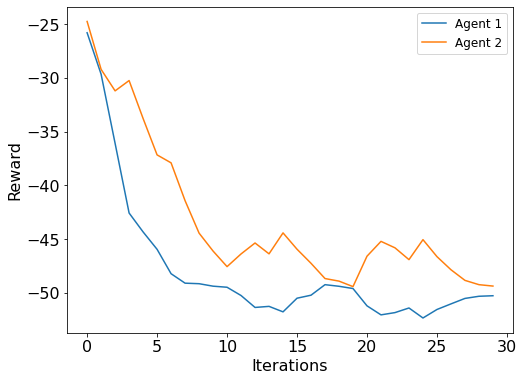

In [60]:
plt.figure(figsize=(8,6));
plt.plot(rewards1, label="Agent 1")
plt.plot(rewards2, label="Agent 2")
# plt.plot(np.array(rewards1)+np.array(rewards2), label="Total reward", linewidth=3, color="black")
plt.legend(fontsize=12);
plt.xlabel("Iterations")
plt.ylabel("Reward");

In [56]:
np.mean([ppo.compute_single_action(([0,0],[0]), policy_id="policy2") for i in range(200)])

/Users/mike/miniconda3/envs/ray2beta/lib/python3.9/site-packages/gym/spaces/box.py:155: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


0.95